In [7]:
from pyDOE import lhs
import matplotlib.pyplot as plt
import numpy as np

In [23]:

omegax = 2*np.pi
omegay = 2*np.pi
r1 = 10
def u_ext(x, y):
    utemp = (0.1*np.sin(omegax*x) + np.tanh(r1*x)) * np.sin(omegay*(y))
    return utemp

N_bound = 80
x_up = 2*lhs(1,N_bound)-1 # random x
y_up = np.empty(len(x_up))[:,None]
y_up.fill(1)
b_up = np.empty(len(x_up))[:,None]
b_up = u_ext(x_up, y_up)
x_up_train = np.hstack((x_up, y_up))
u_up_train = b_up

x_lo = 2*lhs(1,N_bound)-1
y_lo = np.empty(len(x_lo))[:,None]
y_lo.fill(-1)
b_lo = np.empty(len(x_lo))[:,None]
b_lo = u_ext(x_lo, y_lo)
x_lo_train = np.hstack((x_lo, y_lo))
u_lo_train = b_lo

y_ri = 2*lhs(1,N_bound)-1
x_ri = np.empty(len(y_ri))[:,None]
x_ri.fill(1)
b_ri = np.empty(len(y_ri))[:,None]
b_ri = u_ext(x_ri, y_ri)
x_ri_train = np.hstack((x_ri, y_ri))
u_ri_train = b_ri    

y_le = 2*lhs(1,N_bound)-1
x_le = np.empty(len(y_le))[:,None]
x_le.fill(-1)
b_le = np.empty(len(y_le))[:,None]
b_le = u_ext(x_le, y_le)
x_le_train = np.hstack((x_le, y_le))
u_le_train = b_le  


X_u_train = np.concatenate((x_up_train, x_lo_train, x_ri_train, x_le_train))
u_train = np.concatenate((u_up_train, u_lo_train, u_ri_train, u_le_train))
print(X_u_train.shape)
print(u_train.shape)


(320, 2)
(320, 1)


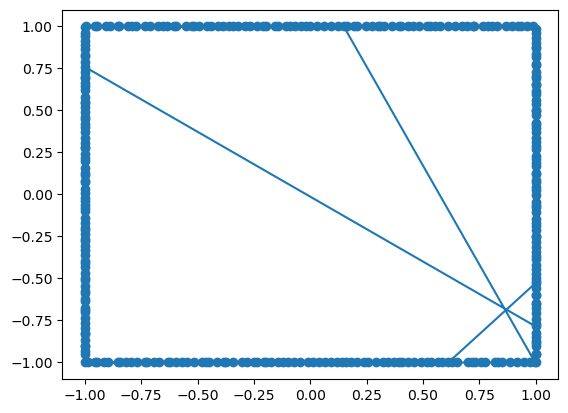

In [27]:
plt.figure()
plt.plot(X_u_train[:,0], X_u_train[:,1], '-o')



In [43]:
def f_ext(x,y):
    gtemp = (-0.1*(omegax**2)*np.sin(omegax*x) - (2*r1**2)*(np.tanh(r1*x))/((np.cosh(r1*x))**2))*np.sin(omegay*(y))\
            +(0.1*np.sin(omegax*x) + np.tanh(r1*x)) * (-omegay**2 * np.sin(omegay*(y)) )
    return gtemp
N_residual = 100    
###########################################################################
# Residual points for PINNs
grid_pt = lhs(2,N_residual)
xf = 2*grid_pt[:,0]-1
yf = 2*grid_pt[:,1]-1
ff = np.asarray([ f_ext(xf[j],yf[j]) for j in range(len(yf))])
X_f_train = np.hstack((xf[:,None],yf[:,None]))
f_train = ff[:,None]


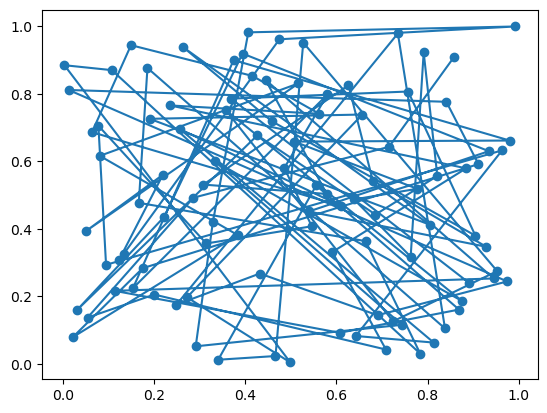

In [34]:
plt.figure()
plt.plot(grid_pt[:,0], grid_pt[:,1], '-o')
# plt.plot(np.arange(len(f_train)), f_train, '-o')
plt.show()


In [41]:
x = np.arange(0, 2*np.pi, 0.01)
y = np.arange(0, 2*np.pi, 0.01)
f = f_ext(x,y)
print(f.shape)

(629,)


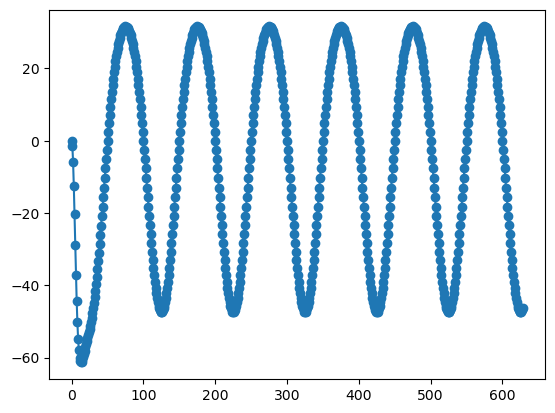

In [42]:
plt.figure()
plt.plot(np.arange(len(f)), f, '-o')
plt.show()

In [50]:
from scipy.special import roots_jacobi
from scipy.special import gamma
from scipy.special import jacobi
##################################################################
# Recursive generation of the Jacobi polynomial of order n
def Jacobi(n,a,b,x):
    x=np.array(x)
    return (jacobi(n,a,b)(x))
    
##################################################################
# Derivative of the Jacobi polynomials
def DJacobi(n,a,b,x,k: int):
    x=np.array(x)
    ctemp = gamma(a+b+n+1+k)/(2**k)/gamma(a+b+n+1)
    return (ctemp*Jacobi(n-k,a+k,b+k,x))

    
##################################################################
# Weight coefficients
def GaussJacobiWeights(Q: int,a,b):
    [X , W] = roots_jacobi(Q,a,b)
    return [X, W]
	
def GaussLobattoJacobiWeights(Q: int,a,b):
    W = []
    X = roots_jacobi(Q-2,a+1,b+1)[0]
    if a == 0 and b==0:
        W = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,X)**2) )
        Wl = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,-1)**2) )
        Wr = 2/( (Q-1)*(Q)*(Jacobi(Q-1,0,0,1)**2) )
    else:
        W = 2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,X)**2) )
        Wl = (b+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,-1)**2) )
        Wr = (a+1)*2**(a+b+1)*gamma(a+Q)*gamma(b+Q)/( (Q-1)*gamma(Q)*gamma(a+b+Q+1)*(Jacobi(Q-1,a,b,1)**2) )
    W = np.append(W , Wr)
    W = np.append(Wl , W)
    X = np.append(X , 1)
    X = np.append(-1 , X)    
    return [X, W]
###########################################################################
# Quadrature points
N_quad = 10
[X_quad, WX_quad] = GaussLobattoJacobiWeights(N_quad, 0, 0)
Y_quad, WY_quad   = (X_quad, WX_quad)
xx, yy            = np.meshgrid(X_quad,  Y_quad)
wxx, wyy          = np.meshgrid(WX_quad, WY_quad)
XY_quad_train     = np.hstack((xx.flatten()[:,None],  yy.flatten()[:,None]))
WXY_quad_train    = np.hstack((wxx.flatten()[:,None], wyy.flatten()[:,None]))
print(WXY_quad_train.shape)

(100, 2)


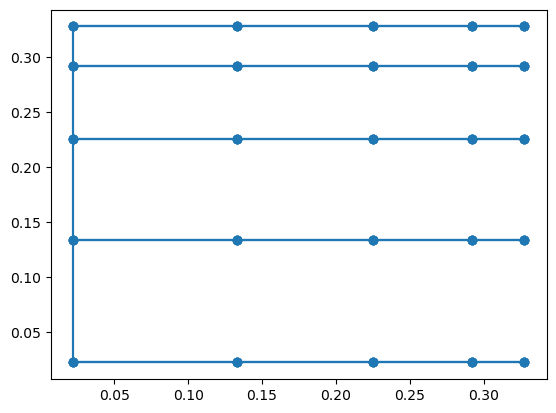

In [51]:
plt.figure()
plt.plot(WXY_quad_train[:,0], WXY_quad_train[:,1], '-o')
plt.show()

In [61]:

Net_layer = [2] + [5] * 3 + [1]
var_form  = 1
N_el_x = 4
N_el_y = 4
N_test_x = N_el_x*[5]
N_test_y = N_el_y*[5]

###########################################################################
def Test_fcn_x(n,x):
    test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
    return test
def Test_fcn_y(n,y):
    test  = Jacobi(n+1,0,0,y) - Jacobi(n-1,0,0,y)
    return test
###########################################################################
# Construction of RHS for VPINNs
NE_x, NE_y = N_el_x, N_el_y
[x_l, x_r] = [-1, 1]
[y_l, y_u] = [-1, 1]
delta_x    = (x_r - x_l)/NE_x
delta_y    = (y_u - y_l)/NE_y
grid_x     = np.asarray([ x_l + i*delta_x for i in range(NE_x+1)])
grid_y     = np.asarray([ y_l + i*delta_y for i in range(NE_y+1)])

#    N_testfcn_total = [(len(grid_x)-1)*[N_test_x], (len(grid_y)-1)*[N_test_y]]
N_testfcn_total = [N_test_x, N_test_y]

#+++++++++++++++++++
x_quad  = XY_quad_train[:,0:1]
y_quad  = XY_quad_train[:,1:2]
w_quad  = WXY_quad_train
U_ext_total = []
F_ext_total = []
print("NE_x:", NE_x, ", NE_y:", NE_y)
for ex in range(NE_x):
    for ey in range(NE_y):
        Ntest_elementx  = N_testfcn_total[0][ex]
        Ntest_elementy  = N_testfcn_total[1][ey]
        x_quad_element = grid_x[ex] + (grid_x[ex+1]-grid_x[ex])/2*(x_quad+1)
        y_quad_element = grid_y[ey] + (grid_y[ey+1]-grid_y[ey])/2*(y_quad+1)
        jacobian       = ((grid_x[ex+1]-grid_x[ex])/2)*((grid_y[ey+1]-grid_y[ey])/2)
        
        testx_quad_element = np.asarray([ Test_fcn_x(n,x_quad)  for n in range(1, Ntest_elementx+1)])
        testy_quad_element = np.asarray([ Test_fcn_y(n,y_quad)  for n in range(1, Ntest_elementy+1)])

        u_quad_element = u_ext(x_quad_element, y_quad_element)
        f_quad_element = f_ext(x_quad_element, y_quad_element)
        
        U_ext_element = np.asarray([[jacobian*np.sum(\
                        w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*u_quad_element) \
                        for r in range(Ntest_elementx)] for k in range(Ntest_elementy)])

        F_ext_element = np.asarray([[jacobian*np.sum(\
                        w_quad[:,0:1]*testx_quad_element[r]*w_quad[:,1:2]*testy_quad_element[k]*f_quad_element) \
                        for r in range(Ntest_elementx)] for k in range(Ntest_elementy)])
        
        U_ext_total.append(U_ext_element)

        F_ext_total.append(F_ext_element)
        break
    break
#    U_ext_total = np.reshape(U_ext_total, [NE_x, NE_y, N_test_y, N_test_x])
F_ext_total = np.reshape(F_ext_total, [NE_x, NE_y, N_test_y[0], N_test_x[0]])
print("F_ext_total:", F_ext_total.shape)

NE_x: 4 , NE_y: 4
(5, 100, 1)


ValueError: cannot reshape array of size 25 into shape (4,4,5,5)